# TOF data
Data taken at intervals of $T=0.1ms$, where $T$ represents the period of free flight after trapping. Captured in sequences of 10 ranging from 0.1ms to 1.0ms. 

In [2]:
#Imports

#path tools
from pathlib import Path
import os

#image processing
from skimage.io import imread, imshow
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter

#other utils
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.contingency import margins #compute marginals
from scipy.optimize import curve_fit

wd = Path(os.getcwd()) #current working directory
np.seterr(divide='ignore'); #doesn't end up mattering, suppress the annoying warning

In [3]:
DATA_DIR = Path("../data/mar02/")

#count from .1 to 1.0 in intervals of 1 and then start over
time_data = list(zip(*product(range(10), np.arange(.1,1.1,.1))))[1]
data = []

In [6]:
for i,time in enumerate(time_data):
    print(i, time)
    data.append(
        DataRun(11+i, time)
    )

0 0.1


/tmp/ipykernel_374156/2969234111.py:46: RuntimeWarning: invalid value encountered in divide
  I_div_arr = np.divide(I_arr, I0_arr)


1 0.2
2 0.30000000000000004
3 0.4
4 0.5
5 0.6
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/lasercooling/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_374156/2489518282.py", line 4, in <module>
    DataRun(11+i, time)
  File "/tmp/ipykernel_374156/2969234111.py", line 7, in __init__
    self.load()
  File "/tmp/ipykernel_374156/2969234111.py", line -1, in load
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/lasercooling/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ben/anaconda3/envs/lasercooling/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(

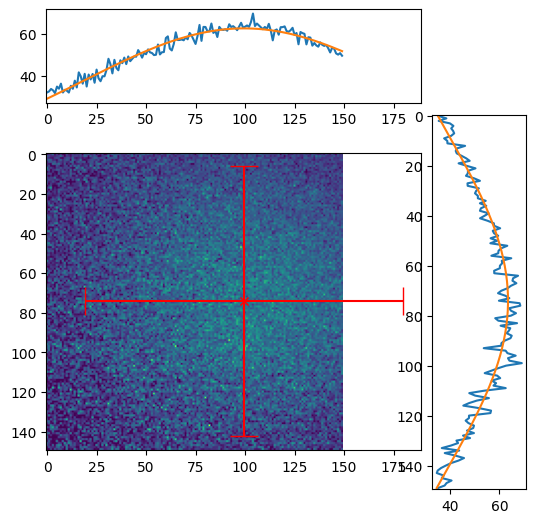

In [10]:
data[4].plot_fit()

In [5]:
class DataRun:
    def __init__(self, num, time):
        self.num = num
        self.time = time

        self.images()
        self.load()
        #self.mask(.20)
        #extract blob rectangle from image
        self.blob_image = self.od_arr[605-75:605+75, 620-75:620+75]
        #[round(self.cy)-75:round(self.cy)+75, round(self.cx)-75:round(self.cx)+75]
        #apply a median filter
        self.fit()

    def incircle(self, center, radius, pt):
            return (pt[0]-center[0])**2 + (pt[1]-center[1])**2 < radius**2

    def images(self):
        images =  [imread(DATA_DIR / f"image_{self.num}_{i}.tif") for i in range(4)]

        im0 = images[0]
        im0_background = images[2]
        im1 = images[1]
        im1_background = images[3]

        I0_arr=np.subtract(np.array(im0),
                            np.array(im0_background)).astype(int)
        I_arr=np.subtract(np.array(im1),
                            np.array(im1_background)).astype(int)

        return I_arr, I0_arr

    def grow_box(self,box, factor):
        width = box[3]-box[1]
        height = box[2]-box[0]
        x1 = round(box[1] - width*factor)
        y1 = round(box[0] - height*factor)
        x2 = round(box[3] + width*factor)
        y2 = round(box[2] + height*factor)
        return (x1,y1,x2,y2)

    def load(self):

        I_arr, I0_arr = self.images()

        I_div_arr = np.divide(I_arr, I0_arr)
        od_arr = np.log(I_div_arr)

        #first pass, just clip anything not within the aperture
        for i,row in enumerate(od_arr):
            for j, pixel in enumerate(row):
                if pixel < 0 or not self.incircle((605,620),150,(i,j)):
                    od_arr[i][j] = 0

        self.od_arr = od_arr

    def mask(self, threshhold):
        value_mask = self.od_arr[:,:] > threshhold
        self.mask_filtered = median_filter(value_mask, 50)

        blobs = label(self.mask_filtered)
        props = regionprops(blobs) #generate a properties dictionary

        if not props:
            return 0

        self.cy, self.cx = props[0].centroid

        return props[0].num_pixels

    def gaussian_fit(self, x, A, mu, sigma):
        return A*np.exp(-(x-mu)**2/(2*sigma**2))
    
    def fit(self):
        #compute marginals and fit to a gaussian

        x, y = margins(self.blob_image)
        x = x.T[0]
        y = y[0]

        x[x == np.inf] = 0
        y[y == np.inf] = 0

        self.popt_x, self.pcov_x = curve_fit(self.gaussian_fit, np.arange(len(x)), x, p0 =[350, 150, 60])
        self.popt_y, self.pcov_y = curve_fit(self.gaussian_fit, np.arange(len(y)), y, [350,150,60])

        self.x = x
        self.y = y

    def atom_number(self):
        x = np.linspace(-1000, 1000, 10000)
        return np.trapz(self.gaussian_fit(x, *self.popt_x),x)*np.trapz(self.gaussian_fit(x, *self.popt_y),x)

    def plot_box(self):
        #draw bounding box
        fig, ax = plt.subplots()
        rect = plt.Rectangle((self.box[0], self.box[1]), self.box[2]-self.box[0], self.box[3]-self.box[1])
        rect.set(fill=False, color = "red")
        ax.add_artist(rect)
        ax.imshow(self.od_arr)

    def plot_blob(self):
        plt.imshow(self.mask_filtered)

    def plot_fit(self):

        fig = plt.figure(figsize=(6,6))
        gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                            left=0.1, right=0.9, bottom=0.1, top=0.9,
                            wspace=0.05, hspace=0.05)
        ax = fig.add_subplot(gs[1,0])
        ax.imshow(self.blob_image)

        #axes are flipped!!
        ax_y = fig.add_subplot(gs[0,0], sharex=ax)
        ax_x = fig.add_subplot(gs[1,1], sharey=ax)

        ax_y.plot(self.y)
        ax_y.plot(np.arange(len(self.y)), self.gaussian_fit(np.arange(len(self.y)),*self.popt_y))

        ax_x.plot(self.x, np.arange(len(self.x)))
        ax_x.plot(self.gaussian_fit(np.arange(len(self.x)),*self.popt_x),np.arange(len(self.x)))

        ax.errorbar(self.popt_y[1], self.popt_x[1], xerr = np.abs(self.popt_y[2]), yerr = np.abs(self.popt_x[2]), color = 'r', marker = "x", capsize = 10)

In [143]:
time_list = np.arange(.1, 1.1, .1)
organized_data = {time : [] for time in time_list}
sigma_times = {time : [] for time in time_list}
for datum in data:
    organized_data[datum.time].append(datum)
    sigma_times[datum.time].append(datum.popt_x[2]**2)

In [142]:
errs = [np.std(sigma_times[i]) for i in sigma_times.keys()]
means = [np.mean(sigma_times[i]) for i in sigma_times.keys()]

In [144]:
eccentricities = []
for key in organized_data:
    sigma_x_list = []
    sigma_y_list = []
    for datum in organized_data[key]:
        sigma_x_list.append(np.abs(datum.popt_x[2]))
        sigma_y_list.append(np.abs(datum.popt_y[2]))
    sigma_x_list = np.array(sigma_x_list)
    sigma_y_list = np.array(sigma_y_list)
    eccentricities.append(np.mean(sigma_x_list/sigma_y_list))

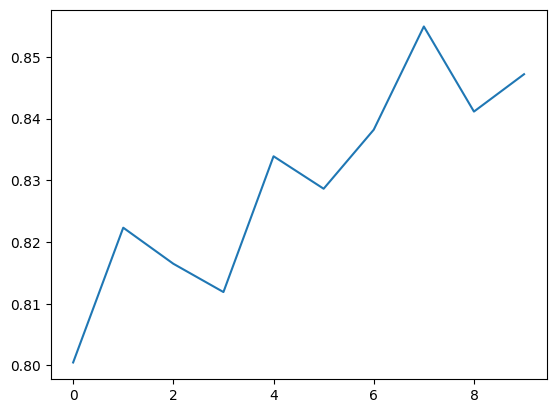

In [145]:
plt.plot(eccentricities)

In [146]:
fit = lambda t, a, b : a*t**2+b
popt, pcov = curve_fit(fit, np.arange(.1, 1.1, .1), means)

Text(0, 0.5, '$\\sigma$ (mm)')

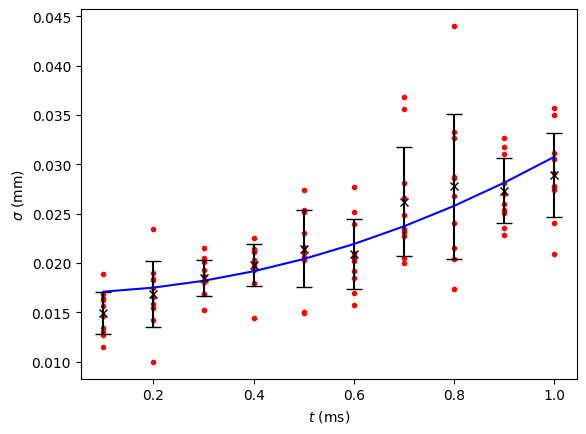

In [175]:
plt.errorbar(time_list,np.array(means)*(dist*1e3)**2, yerr = np.array(errs)*(dist*1e3)**2, c= "k", capsize = 6, linestyle = "None", marker = "x")
for d in data:
    plt.scatter(d.time, np.abs(d.popt_x[2]**2)*(dist*1e3)**2, marker = ".", color = "r") 
plt.plot(time_list, fit(time_list, *popt)*(dist*1e3)**2, c = "b")
plt.xlabel(r"$t$ (ms)")
plt.ylabel(r"$\sigma$ (mm)")

In [176]:
v_rms = np.sqrt(popt[0])*dist*1e3

In [177]:
v_rms

0.11751124029005938

First, we have $\langle (x+vt)^2 \rangle = \langle x^2 \rangle + \langle v^2\rangle t^2$, using $\langle v \rangle = 0$, and thus the fit parameter $a$ gives the RMS velocity. Plugging this into the Maxwell-Bolzmann distribution,
$$
v_{rms} = \sqrt{\frac{3RT}{M}} \Rightarrow T = \frac{v_{rms}^2 M}{3R}
$$

In [152]:
v_rms**2*39.1/(3*8.315)*1e3

21.644724848477278

In [127]:
dist = .33*6.45e-6